In [1]:
import mopdbrs2


In [2]:
import pg8000

In [3]:
creds = mopdbrs2.get_creds()

creds['ssl_context']=True

con = pg8000.connect(**creds) 




/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iibs-midway.corp.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'midway-auth.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iibs-midway.corp.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readth

In [4]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
from dateutil.parser import parse
import math
import random 

In [5]:

sql= """
    WITH dosp AS (SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_day)))) AS ship_week
    ,SUBSTRING(shipping_address_postal_code,1,5) AS zipcode
    ,OTM_OBCUST_PKG_REC_ID
    ,warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM booker.d_outbound_shipment_packages_na
    WHERE region_id = 1
      AND legal_entity_id = 101
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(warehouse_id) NOT IN ('PTOP')
    )


 SELECT ship_week
    ,zipcode
    ,count(OTM_OBCUST_PKG_REC_ID) as pkgs
    FROM dosp
    INNER JOIN trans_dims_ddl.warehouses w
      ON dosp.warehouse_id = w.warehouse_id
      AND w.legal_entity_id = 101
      AND w.is_sortcenter = 'N'                                           
      AND w.is_prime_now = 'N'                                            
      AND w.is_fresh = 'N'
    WHERE dosp.marketplace_id = 1 
      AND ship_week < trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, GETDATE()))))
      AND ship_week >= trunc(dateadd('day', -1, date_trunc('week',dateadd('day', 1, dateadd('week',-212, GETDATE())))))
      AND zipcode IN ('37217', '37920')
    GROUP BY 1,
             2
    ORDER BY 1;
    
    """
q=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
q.head()


,zipcode,pkgs
ship_week,,
2017-05-14,37217,3217
2017-05-14,37920,4184
2017-05-21,37217,3135
2017-05-21,37920,4196
2017-05-28,37217,3039


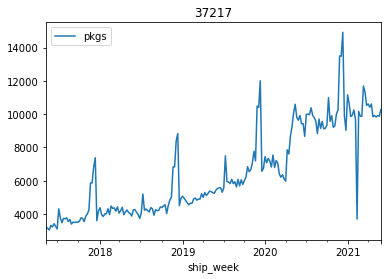

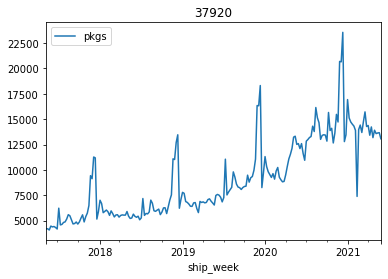

In [6]:
#q = pd.DataFrame( 'zipcode', 'ship_week')

grp = q.groupby('zipcode')
for key in grp.groups.keys():
    grp.get_group(key).plot(title=key)

In [20]:


def plot_q(df, x, y, title="", xlabel='ship_week', ylabel='pkgs', dpi=100):
    q.groupby('zipcode')['pkgs'].plot(legend=True)
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
#plot_q(q, x=q.index, y=q.pkgs, title='Yearly')    


zipcode
37217    AxesSubplot(0.125,0.125;0.775x0.755)
37920    AxesSubplot(0.125,0.125;0.775x0.755)
Name: pkgs, dtype: object

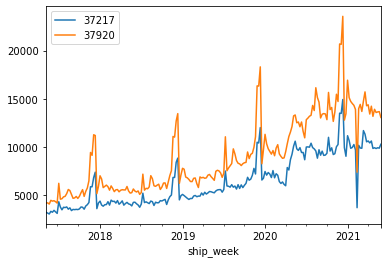

In [7]:
#q.set_index('ship_week', inplace=True)
q.groupby('zipcode')['pkgs'].plot(legend=True)

In [8]:
q.reset_index()

,ship_week,zipcode,pkgs
0,2017-05-14,37217,3217
1,2017-05-14,37920,4184
2,2017-05-21,37217,3135
3,2017-05-21,37920,4196
4,2017-05-28,37217,3039
...,...,...,...
419,2021-05-16,37217,9917
420,2021-05-23,37920,13666
421,2021-05-23,37217,9877
422,2021-05-30,37217,10281


## Creating Subplots of differents zipcodes (4 CA FSAs)

## Canada data with all the FSAs

In [5]:
#subquery added

sql = """

WITH dosp AS (SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_day)))) AS ship_week
    ,SUBSTRING(shipping_address_postal_code,1,3) AS zipcode
    ,OTM_OBCUST_PKG_REC_ID
    ,warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM booker.d_outbound_shipment_packages_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(warehouse_id) NOT IN ('PTOP')
    )


 SELECT ship_week
    ,zipcode
    ,count(OTM_OBCUST_PKG_REC_ID) as pkgs
    FROM dosp
    INNER JOIN trans_dims_ddl.warehouses w
      ON dosp.warehouse_id = w.warehouse_id
      AND w.legal_entity_id = 115
      AND w.is_sortcenter = 'N'                                           
      AND w.is_prime_now = 'N'                                            
      AND w.is_fresh = 'N'
    WHERE dosp.marketplace_id = 7
      AND ship_week < trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, GETDATE()))))
      AND ship_week >= trunc(dateadd('day', -1, date_trunc('week',dateadd('day', 1, dateadd('week',-212, GETDATE())))))
      AND zipcode IN (select "left"(destination_postal_code,3) as fsa
    from perfectmile.d_perfectmile_pkg_attributes_v2_na
    where marketplace_id = 7
    and ship_date >= to_date('20200101','YYYYMMDD')
    and not(left(fsa,1) ~ '^[0-9]')
    group by 1
    having count(*) > 1000)
    GROUP BY 1,
             2
    ORDER BY 1;
    
    """
    

In [6]:
m=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
print(m)

           zipcode  pkgs
ship_week               
2017-05-21     H2P   399
2017-05-21     N9G   352
2017-05-21     P3A   475
2017-05-21     P2N   230
2017-05-21     K2J  1938
...            ...   ...
2021-06-06     V1G  2265
2021-06-06     L0J  1350
2021-06-06     L0C  2348
2021-06-06     N8T  2875
2021-06-06     G8B  1536

[348180 rows x 2 columns]


In [7]:
m.reset_index()
m.describe()

,pkgs
count,348180.000000
mean,1982.968223
std,2559.021451
min,1.000000
25%,449.000000
50%,1132.000000
75%,2516.000000
max,44060.000000


In [8]:
#Percentage short form without 100
zip3 = m.groupby(['ship_week','zipcode']).sum()/m.groupby(['ship_week']).sum()
zip3

pkgs
ship_week  zipcode          
2017-05-21 A0A      0.000465
           A0B      0.000208
           A0C      0.000117
           A0E      0.000241
           A0G      0.000460
...                      ...
2021-06-06 X0G      0.000001
           X1A      0.000544
           Y0A      0.000002
           Y0B      0.000005
           Y1A      0.000609

[348180 rows x 1 columns]

In [78]:
#avg of number of packages/postal codes 
df= m.groupby(['zipcode'], sort=False).mean()
df.head()

NameError: name 'm' is not defined

In [10]:
#postalcodes that have < 7 shippment/week on the average
df[df['pkgs'] < 7]

,pkgs
zipcode,
T0V,3.989247
X0G,4.611940


In [11]:
#zipcodes placed in percentiles 
df1 = pd.cut(df.pkgs, np.percentile(df.pkgs, [0, 1, 5, 25, 50, 75, 95, 99, 100]),
                  include_lowest=True)
df1

zipcode
H2P      (659.479, 1500.189]
N9G      (1500.189, 2745.17]
P3A      (1500.189, 2745.17]
P2N      (659.479, 1500.189]
K2J    (9261.351, 15915.458]
               ...          
R5N       (119.111, 659.479]
R5L       (119.111, 659.479]
R5T        (32.426, 119.111]
R5R       (119.111, 659.479]
R5P        (32.426, 119.111]
Name: pkgs, Length: 1651, dtype: category
Categories (8, interval[float64]): [(3.988, 32.426] < (32.426, 119.111] < (119.111, 659.479] < (659.479, 1500.189] < (1500.189, 2745.17] < (2745.17, 5290.479] < (5290.479, 9261.351] < (9261.351, 15915.458]]

In [12]:
df2 = df1.cat.rename_categories([1, 5, 25, 50, 75, 95, 99, 100])
df2

zipcode
H2P     50
N9G     75
P3A     75
P2N     50
K2J    100
      ... 
R5N     25
R5L     25
R5T      5
R5R     25
R5P      5
Name: pkgs, Length: 1651, dtype: category
Categories (8, int64): [1 < 5 < 25 < 50 < 75 < 95 < 99 < 100]

In [37]:
#df4 = df2.groupby('zipcode').nunique()  #find out what to do here 

In [13]:
df3 = df2.groupby(df2).sample(n=1, random_state=1)
df3

zipcode
H4Y      1
B1J      5
S6X     25
H7Y     50
H1X     75
N0R     95
V4N     99
M5V    100
Name: pkgs, dtype: category
Categories (8, int64): [1 < 5 < 25 < 50 < 75 < 95 < 99 < 100]

In [5]:
# pulled data for the eight postalcodes from each percentile 

sql= """

WITH dosp AS (SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_day)))) AS ship_week
    ,SUBSTRING(shipping_address_postal_code,1,3) AS zipcode
    ,OTM_OBCUST_PKG_REC_ID
    ,warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM booker.d_outbound_shipment_packages_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(warehouse_id) NOT IN ('PTOP')
    )


 SELECT ship_week
    ,zipcode
    ,count(OTM_OBCUST_PKG_REC_ID) as pkgs
    FROM dosp
    INNER JOIN trans_dims_ddl.warehouses w
      ON dosp.warehouse_id = w.warehouse_id
      AND w.legal_entity_id = 115
      AND w.is_sortcenter = 'N'                                           
      AND w.is_prime_now = 'N'                                            
      AND w.is_fresh = 'N'
    WHERE dosp.marketplace_id = 7
      AND ship_week < trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, GETDATE()))))
      AND ship_week >= trunc(dateadd('day', -1, date_trunc('week',dateadd('day', 1, dateadd('week',-212, GETDATE())))))
      AND zipcode IN ('M7A','B0L','B0R','G2K', 'V6V', 'M4S', 'J0K', 'V3S')
    GROUP BY 1,
             2
    ORDER BY 1;
    
    """
    

In [6]:
new_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
new_df.head(5)

,zipcode,pkgs
ship_week,,
2017-05-28,B0L,26
2017-05-28,B0R,69
2017-05-28,M4S,1546
2017-05-28,V6V,681
2017-05-28,M7A,22


In [7]:
new_df.shape

(1695, 2)

In [8]:
#pulling V3S zipcode for modeling 

new_zip1 = new_df[new_df.zipcode == 'V3S']
new_zip1

,zipcode,pkgs
ship_week,,
2017-05-28,V3S,2438
2017-06-04,V3S,2284
2017-06-11,V3S,2591
2017-06-18,V3S,2444
2017-06-25,V3S,2417
...,...,...
2021-05-16,V3S,17145
2021-05-23,V3S,17811
2021-05-30,V3S,17214


array([[<AxesSubplot:title={'center':'pkgs'}>]], dtype=object)

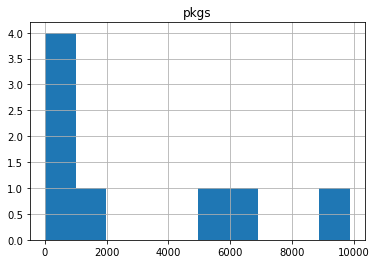

In [9]:
#avg of number of packages/postal codes 
new_df1= new_df.groupby(['zipcode'], sort=False).mean()
new_df1.head(10).hist()

In [10]:
new_df1= new_df.groupby(['zipcode'], sort=False).sum()
new_df1

,pkgs
zipcode,
B0L,21841
B0R,68408
M4S,1119803
V6V,379320
M7A,4602
J0K,1337501
G2K,163163
V3S,2091780


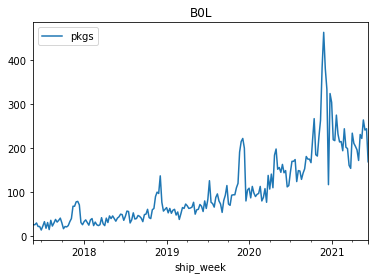

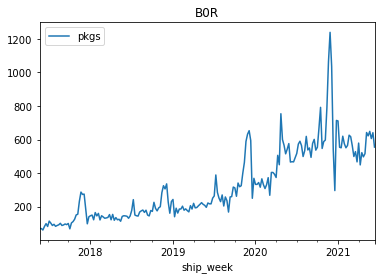

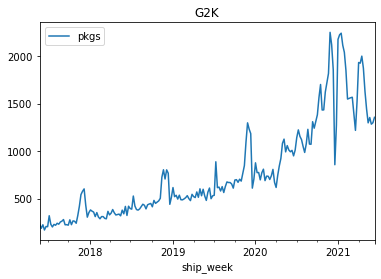

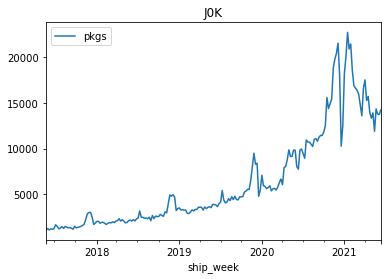

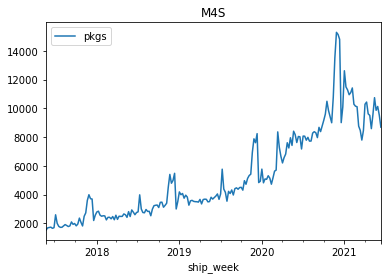

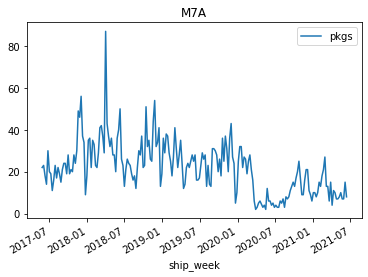

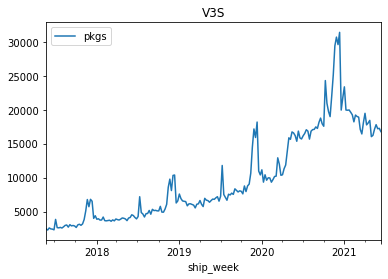

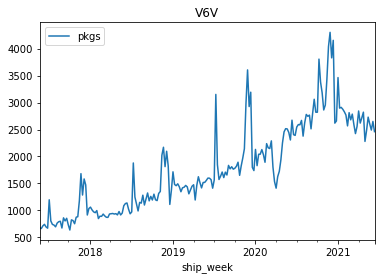

In [11]:
grp1 = new_df.groupby('zipcode')
for key in grp1.groups.keys():
    grp1.get_group(key).plot(title=key)

zipcode
B0L    AxesSubplot(0.125,0.125;0.775x0.755)
B0R    AxesSubplot(0.125,0.125;0.775x0.755)
G2K    AxesSubplot(0.125,0.125;0.775x0.755)
J0K    AxesSubplot(0.125,0.125;0.775x0.755)
M4S    AxesSubplot(0.125,0.125;0.775x0.755)
M7A    AxesSubplot(0.125,0.125;0.775x0.755)
V3S    AxesSubplot(0.125,0.125;0.775x0.755)
V6V    AxesSubplot(0.125,0.125;0.775x0.755)
Name: pkgs, dtype: object

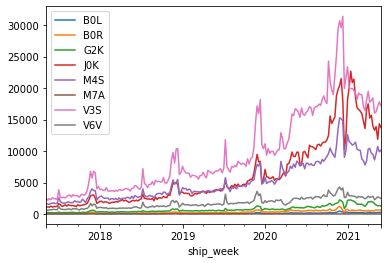

In [69]:
def plot_new_df(new_df, x, y, title="", xlabel='ship_week', ylabel='pkgs', dpi=100):
    plt.figure(figsize=(20,10), dpi=dpi)
new_df.groupby('zipcode')['pkgs'].plot(legend=True)

In [12]:
new_df2 = new_df.groupby(['ship_week','zipcode']).sum()/new_df.groupby(['ship_week']).sum()*100
new_df2

pkgs
ship_week  zipcode           
2017-05-28 B0L       0.426509
           B0R       1.131890
           G2K       3.789370
           J0K      17.765748
           M4S      25.360892
...                       ...
2021-06-13 J0K      32.139549
           M4S      19.648869
           M7A       0.018076
           V3S      37.937501
           V6V       5.558443

[1695 rows x 1 columns]

In [22]:
#Updated and Modified sql codes for Canada data


sql = """

WITH pka_dosp AS (SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_day)))) AS ship_week
    ,SUBSTRING(shipping_address_postal_code,1,3) AS zipcode
    ,OTM_OBCUST_PKG_REC_ID
    ,warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM booker.d_outbound_shipment_packages_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(warehouse_id) NOT IN ('PTOP')
      AND shipping_address_country_code = 'CA'
      AND ship_week < '2021-05-02'
      AND ship_week >= trunc(dateadd('day', -1, date_trunc('week',dateadd('day', 1, dateadd('week',-212, GETDATE())))))
      AND marketplace_id=7
    UNION
     SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_date)))) AS ship_week
    ,SUBSTRING(destination_postal_code,1,3) AS zipcode
    ,fulfillment_shipment_id AS OTM_OBCUST_PKG_REC_ID
    ,originating_fulfillment_center AS warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM perfectmile_ext.d_perfectmile_pkg_attributes_v2_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(originating_fulfillment_center) NOT IN ('PTOP')
      AND destination_country_code = 'CA'
      AND ship_week < trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, GETDATE()))))
      AND ship_week >= '2021-05-02'
      AND marketplace_id=7
    )


SELECT ship_week
    ,pka_dosp.zipcode
    ,count(OTM_OBCUST_PKG_REC_ID) as pkgs
FROM pka_dosp
    INNER JOIN trans_dims_ddl.warehouses w
    ON pka_dosp.warehouse_id = w.warehouse_id
    AND w.legal_entity_id = 115
    AND w.is_sortcenter = 'N'                                           
    AND w.is_prime_now = 'N'                                            
    AND w.is_fresh = 'N'
    and zipcode in (select "left"(destination_postal_code,3) as fsa
from perfectmile.d_perfectmile_pkg_attributes_v2_na
where marketplace_id = 7
and ship_date >= to_date('20200101','YYYYMMDD')
and not(left(fsa,1) ~ '^[0-9]')
group by 1
having count(*) > 1000)
GROUP BY 1,
         2
ORDER BY 1,2;
    
    """


In [23]:
mod_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
mod_df

,zipcode,pkgs
ship_week,,
2017-05-21,A0A,378
2017-05-21,A0B,169
2017-05-21,A0C,95
2017-05-21,A0E,196
2017-05-21,A0G,374
...,...,...
2021-06-06,X0G,6
2021-06-06,X1A,3255
2021-06-06,Y0A,12


In [24]:
#avg of number of packages/postal codes 
mod_df1= mod_df.groupby(['zipcode'], sort=False).mean()
mod_df1.head()

,pkgs
zipcode,
A0A,1380.622642
A0B,715.787736
A0C,371.721698
A0E,715.627358
A0G,1308.641509


In [25]:
#postalcodes that have < 7 shippment/week on the average
mod_df1[mod_df1['pkgs'] < 7]

,pkgs
zipcode,
T0V,3.989247
X0G,4.616915


In [26]:
#merge the old and new dataframes; m and mod_df

merge_inner = m.merge (mod_df, left_on=['zipcode', 'ship_week'], right_on =['zipcode', 'ship_week'])
                       
merge_inner.head(5)

,zipcode,pkgs_x,pkgs_y
ship_week,,,
2017-05-21,H2P,399,399
2017-05-21,N9G,352,352
2017-05-21,P3A,475,475
2017-05-21,P2N,230,230
2017-05-21,K2J,1938,1938


In [27]:
#take the difference
merge_inner['pkgs_diff'] = merge_inner['pkgs_x'] - merge_inner['pkgs_y']



merge_inner['pkgs_abs']= merge_inner['pkgs_diff'].abs()

In [96]:
merge_inner

,zipcode,pkgs_x,pkgs_y,pkgs_diff,pkgs_abs
ship_week,,,,,
2017-05-21,K2J,1938,1938,0,0
2017-05-21,T7E,314,314,0,0
2017-05-21,V7S,276,276,0,0
2017-05-21,N9G,352,352,0,0
2017-05-21,H2P,399,399,0,0
...,...,...,...,...,...
2021-06-06,J4G,1322,1322,0,0
2021-06-06,L0J,1350,1350,0,0
2021-06-06,V1G,2265,2264,1,1


In [28]:
mean_abs = merge_inner.groupby(['zipcode'])['pkgs_abs'].mean().sort_values()
mean_abs.tail(20)

zipcode
T2E     25.132075
M3H     25.391509
H3H     25.735849
L6T     27.754717
L4W     31.004717
L3Y     33.033019
L6C     35.721698
L2V     35.816038
L4K     36.933962
L9T     37.334906
L5N     42.014151
M9W     44.099057
L4B     49.688679
L5R     53.726415
V6V     53.811321
L6H     66.683962
L3R     84.891509
M1S    151.235849
L5T    164.981132
L7G    177.419811
Name: pkgs_abs, dtype: float64

In [14]:
#mean_abs = merge_inner.groupby(['zipcode'])['pkgs_abs'].mean().sort_values()/(['pkgs_abs']).mean()

In [99]:
#pulling V3S zipcode for modeling 

new_zip1 = new_df[new_df.zipcode == 'V3S']
new_zip1

,zipcode,pkgs
ship_week,,
2017-05-28,V3S,2438
2017-06-04,V3S,2284
2017-06-11,V3S,2591
2017-06-18,V3S,2444
2017-06-25,V3S,2417
...,...,...
2021-05-16,V3S,17145
2021-05-23,V3S,17811
2021-05-30,V3S,17214


In [1]:
#
# new_zip1.columns = ['ship_week','zipcode','pkgs']
# new_zip1 = new_zip1[(pd.to_datetime(new_zip1['ship_week']).dt.day != 1) |
#                     (pd.to_datetime(new_zip1['ship_week']).dt.month != 1)]

In [15]:
 #split data: Train (3 years; 156weeks), Test (1 year; 52weeks),and Forecast (3 years; 325weeks)

train_data = new_zip1[-4*212:156]
test_data = new_zip1[-52:]
fcst_data = new_zip1[-3*52:]


In [16]:
train_data.shape

(156, 2)

In [17]:
train_data.head()

,zipcode,pkgs
ship_week,,
2017-05-28,V3S,2438
2017-06-04,V3S,2284
2017-06-11,V3S,2591
2017-06-18,V3S,2444
2017-06-25,V3S,2417


In [18]:
test_data.shape

(52, 2)

In [19]:
fcst_data.shape 

(156, 2)

In [20]:
new_zip1

,zipcode,pkgs
ship_week,,
2017-05-28,V3S,2438
2017-06-04,V3S,2284
2017-06-11,V3S,2591
2017-06-18,V3S,2444
2017-06-25,V3S,2417
...,...,...
2021-05-16,V3S,17145
2021-05-23,V3S,17811
2021-05-30,V3S,17214


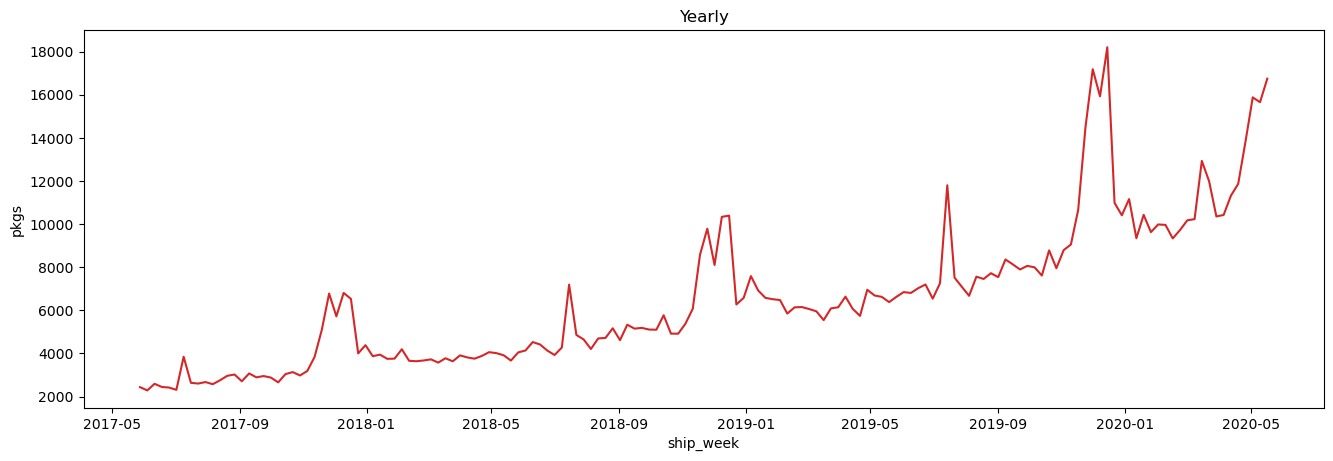

In [21]:
#train data visuals

def plot_train_data(train_data, x, y, title="", xlabel='ship_week', ylabel='pkgs', dpi=100):
    #q.groupby('zipcode')['pkgs'].plot(legend=True)
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_train_data(train_data, x=train_data.index, y=train_data.pkgs, title='Yearly')    


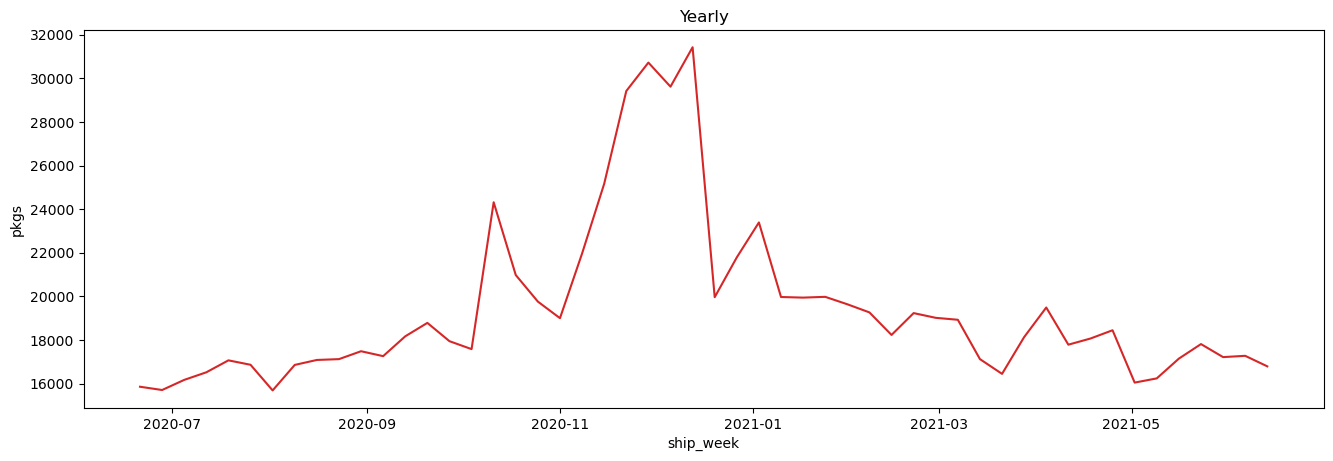

In [22]:
#visualize test data to check the similarity

def plot_test_data(test_data, x, y, title="", xlabel='ship_week', ylabel='pkgs', dpi=100):
    #q.groupby('zipcode')['pkgs'].plot(legend=True)
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_test_data(test_data, x=test_data.index, y=test_data.pkgs, title='Yearly')    


## Moving Average Model 

In [117]:
#difference between moving avg model and moving avg smooothing 

import pandas as pd
from matplotlib import pyplot
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import statistics
from sklearn.model_selection import TimeSeriesSplit

## Dividing the dataset into Training, Testing and Forecasts sets 

In [2]:
train_data = new_zip1[-4*212:156]
train_data.head(20)
train_data.index

NameError: name 'new_zip1' is not defined

In [25]:
train_data1 = train_data.iloc[:,1]
train_data1

ship_week
2017-05-28     2438
2017-06-04     2284
2017-06-11     2591
2017-06-18     2444
2017-06-25     2417
              ...  
2020-04-19    11863
2020-04-26    13817
2020-05-03    15874
2020-05-10    15650
2020-05-17    16743
Name: pkgs, Length: 156, dtype: int64

## Transformation (Ist order difference)

In [1]:
#train_data_diff = train_data1.diff()
train_data_diff = train_data1.diff().fillna(train_data1)
pyplot.plot(train_data_diff)
plt.show()


NameError: name 'train_data1' is not defined

In [118]:
#plot_acf(train_data_diff, lags=20)

In [119]:
#there is a significant acf up to lag 1 and non-significant acf (almost zero) after lag 1. The model
#to be used will be 1 i.e MA(1)
#plot_pacf(train_data_diff, lags=20)

## Fitting the Model AR + MA = ARMA 

In [27]:

#AR(1) & MA(3).
model = ARIMA(train_data_diff, order=(1,0,3))
model_fit = model.fit()
model_fit

/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency i

In [28]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   pkgs   No. Observations:                  156
Model:                     ARMA(1, 3)   Log Likelihood               -1328.676
Method:                       css-mle   S.D. of innovations           1209.657
Date:                Sun, 20 Jun 2021   AIC                           2669.353
Time:                        21:05:05   BIC                           2687.652
Sample:                    05-28-2017   HQIC                          2676.785
                         - 05-17-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        105.1032     84.876      1.238      0.216     -61.250     271.457
ar.L1.pkgs    -0.5050      0.383     -1.318      0.188      -1.256       0.246
ma.L1.pkgs     0.3608      0.377      0.956      0.339      -0.379       1.100
ma.L2.pkgs    -0.0980      0.126     -0.778      0.436      -0.345       0.149
ma.L3.pkgs     0.0542      0.099      0.549      0.583      -0.139       0.248
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9801           +0.0000j            1.9801            0.5000
MA.1           -1.5532           -0.0000j            1.5532           -0.5000
MA.2            1.6806           -3.0088j            3.4463           -0.1689
MA.3            1.6806           +3.0088j            3.4463            0.1689
-----------------------------------------------------------------------------
"""

In [29]:
model_fit.plot_diagnostics(figsize=(15,12)) #check this with team members 

AttributeError: 'ARMAResults' object has no attribute 'plot_diagnostics'

In [30]:
print(model_fit.params)

const         105.103206
ar.L1.pkgs     -0.505017
ma.L1.pkgs      0.360827
ma.L2.pkgs     -0.098010
ma.L3.pkgs      0.054207
dtype: float64


In [68]:
test_data = new_zip1[-52:]

In [69]:
test_data.shape

(52, 2)

In [70]:
test_data1 = test_data.iloc[:,1]
test_data1.head(5)

ship_week
2020-06-21    15855
2020-06-28    15705
2020-07-05    16169
2020-07-12    16517
2020-07-19    17065
Name: pkgs, dtype: int64

In [52]:
#prediction on the test data
pred_model = model_fit.predict(start=156, end=156+52-1)
pred_model.head(10)

2020-05-24     54.798026
2020-05-31     41.641592
2020-06-07    187.072048
2020-06-14     63.707584
2020-06-21    126.008681
2020-06-28     94.545595
2020-07-05    110.434974
2020-07-12    102.410575
2020-07-19    106.463029
2020-07-26    104.416473
Freq: W-SUN, dtype: float64

In [32]:
#from datetime import datetime, date, timedelta
#start_date = datetime(2020,5,17)
#end_date = datetime(2020,5,17) + timedelta(days=52*7)
#model_fit.predict(start=start_date, end=end_date)

## Forecasts

In [35]:
fcst_data = new_zip1[-3*52:]
fcst_data1 = fcst_data.iloc[:,1]
fcst_data1.head(5)

ship_week
2018-06-24    4133
2018-07-01    3926
2018-07-08    4272
2018-07-15    7192
2018-07-22    4858
Name: pkgs, dtype: int64

In [49]:
fct_model = ARIMA(fcst_data1, order=(1,0,3))
fct_fit = fct_model.fit()
fct_fit.summary()

/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency i

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   pkgs   No. Observations:                  156
Model:                     ARMA(1, 3)   Log Likelihood               -1387.203
Method:                       css-mle   S.D. of innovations           1745.950
Date:                Sun, 20 Jun 2021   AIC                           2786.406
Time:                        21:29:47   BIC                           2804.705
Sample:                    06-24-2018   HQIC                          2793.838
                         - 06-13-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.153e+04   3560.145      3.238      0.001    4551.462    1.85e+04
ar.L1.pkgs     0.9728      0.021     47.169      0.000       0.932       1.013
ma.L1.pkgs    -0.1407      0.090     -1.569      0.117      -0.317       0.035
ma.L2.pkgs    -0.0561      0.104     -0.542      0.588      -0.259       0.147
ma.L3.pkgs     0.0306      0.087      0.353      0.724      -0.140       0.201
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0280           +0.0000j            1.0280            0.0000
MA.1           -3.0865           -0.0000j            3.0865           -0.5000
MA.2            2.4602           -2.1295j            3.2539           -0.1136
MA.3            2.4602           +2.1295j            3.2539            0.1136
-----------------------------------------------------------------------------
"""

In [48]:
model_fct = fct_fit.predict(start=156, end=156+352-1)
model_fct.head(10)

2021-06-20    16675.746530
2021-06-27    16561.103905
2021-07-04    16413.580251
2021-07-11    16280.512270
2021-07-18    16151.069551
2021-07-25    16025.153326
2021-08-01    15902.667522
2021-08-08    15783.518682
2021-08-15    15667.615894
2021-08-22    15554.870724
Freq: W-SUN, dtype: float64

## Fitting the Model with Seasonality (AR+MA)

In [55]:
#without differencing or transformation 
model1 = ARIMA(train_data1, order=(1,0,3))
model_fit1 = model1.fit()
model_fit1

/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency i

In [58]:
model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   pkgs   No. Observations:                  156
Model:                     ARMA(1, 3)   Log Likelihood               -1328.866
Method:                       css-mle   S.D. of innovations           1201.495
Date:                Sun, 20 Jun 2021   AIC                           2669.731
Time:                        21:49:19   BIC                           2688.031
Sample:                    05-28-2017   HQIC                          2677.164
                         - 05-17-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7241.9934   2086.746      3.470      0.001    3152.047    1.13e+04
ar.L1.pkgs     0.9581      0.037     26.163      0.000       0.886       1.030
ma.L1.pkgs    -0.0918      0.100     -0.920      0.357      -0.287       0.104
ma.L2.pkgs     0.0223      0.111      0.202      0.840      -0.195       0.239
ma.L3.pkgs     0.0773      0.100      0.771      0.440      -0.119       0.274
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0437           +0.0000j            1.0437            0.0000
MA.1            1.1669           -1.8898j            2.2210           -0.1620
MA.2            1.1669           +1.8898j            2.2210            0.1620
MA.3           -2.6225           -0.0000j            2.6225           -0.5000
-----------------------------------------------------------------------------
"""

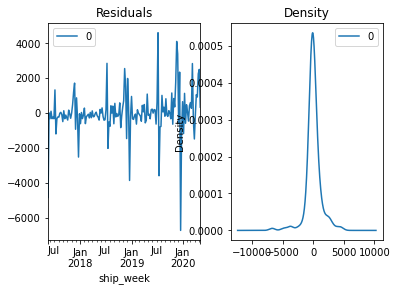

In [37]:
# Plot residual errors
residuals = pd.DataFrame(model_fit1.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [59]:
pred = model_fit1.predict(start=156, end=156+52-1)
pred.tail(20)

2021-01-03    9616.931092
2021-01-10    9517.484030
2021-01-17    9422.201170
2021-01-24    9330.908141
2021-01-31    9243.437874
2021-02-07    9159.630298
2021-02-14    9079.332042
2021-02-21    9002.396159
2021-02-28    8928.681854
2021-03-07    8858.054229
2021-03-14    8790.384032
2021-03-21    8725.547427
2021-03-28    8663.425760
2021-04-04    8603.905347
2021-04-11    8546.877265
2021-04-18    8492.237151
2021-04-25    8439.885013
2021-05-02    8389.725044
2021-05-09    8341.665451
2021-05-16    8295.618283
Freq: W-SUN, dtype: float64

In [60]:
#fct = model_fit1.predict(start=156, end=156+352-1)
#fct.tail(10)

In [61]:
#Converting to dataframe 
#fct.type()
#data_fct = fct.to_frame()
#data_fct1 = data_fct.reset_index()
#data_fct1.columns =['ship_week', 'pkgs_num']
#data_fct1

In [62]:
#model_fit1.plot_predict(dynamic=False)
#plt.show()

## Forecasts

In [71]:
fcst_data = new_zip1[-3*52:]
fcst_data2 = fcst_data.iloc[:,1]
fcst_data2.head(5)

ship_week
2018-06-24    4133
2018-07-01    3926
2018-07-08    4272
2018-07-15    7192
2018-07-22    4858
Name: pkgs, dtype: int64

In [72]:
fct_model1 = ARIMA(fcst_data2, order=(1,0,3))
fct_fit1 = fct_model1.fit()
fct_fit1.summary()

/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency i

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   pkgs   No. Observations:                  156
Model:                     ARMA(1, 3)   Log Likelihood               -1387.203
Method:                       css-mle   S.D. of innovations           1745.950
Date:                Sun, 20 Jun 2021   AIC                           2786.406
Time:                        22:02:54   BIC                           2804.705
Sample:                    06-24-2018   HQIC                          2793.838
                         - 06-13-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.153e+04   3560.145      3.238      0.001    4551.462    1.85e+04
ar.L1.pkgs     0.9728      0.021     47.169      0.000       0.932       1.013
ma.L1.pkgs    -0.1407      0.090     -1.569      0.117      -0.317       0.035
ma.L2.pkgs    -0.0561      0.104     -0.542      0.588      -0.259       0.147
ma.L3.pkgs     0.0306      0.087      0.353      0.724      -0.140       0.201
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0280           +0.0000j            1.0280            0.0000
MA.1           -3.0865           -0.0000j            3.0865           -0.5000
MA.2            2.4602           -2.1295j            3.2539           -0.1136
MA.3            2.4602           +2.1295j            3.2539            0.1136
-----------------------------------------------------------------------------
"""

In [73]:
model_fct1 = fct_fit1.predict(start=156, end=156+352-1)
model_fct1.head(10)

2021-06-20    16675.746530
2021-06-27    16561.103905
2021-07-04    16413.580251
2021-07-11    16280.512270
2021-07-18    16151.069551
2021-07-25    16025.153326
2021-08-01    15902.667522
2021-08-08    15783.518682
2021-08-15    15667.615894
2021-08-22    15554.870724
Freq: W-SUN, dtype: float64

## Seasonal ARIMA Model

In [100]:
new_zip1 = new_df[new_df.zipcode == 'V3S']
new_zip1

,zipcode,pkgs
ship_week,,
2017-05-28,V3S,2438
2017-06-04,V3S,2284
2017-06-11,V3S,2591
2017-06-18,V3S,2444
2017-06-25,V3S,2417
...,...,...
2021-05-16,V3S,17145
2021-05-23,V3S,17811
2021-05-30,V3S,17214


In [91]:
new_train = new_zip1[-4*212:156]
new_test = new_zip1[-52:]
new_fct = new_zip1[-3*52:]

In [105]:
new_train1 = new_train.iloc[:,1]
new_train1

ship_week
2017-05-28     2438
2017-06-04     2284
2017-06-11     2591
2017-06-18     2444
2017-06-25     2417
              ...  
2020-04-19    11863
2020-04-26    13817
2020-05-03    15874
2020-05-10    15650
2020-05-17    16743
Name: pkgs, Length: 156, dtype: int64

In [140]:
new_test = new_zip1[-52:]
new_test1 = new_test.iloc[:,1]
new_test1.head()

ship_week
2020-06-21    15855
2020-06-28    15705
2020-07-05    16169
2020-07-12    16517
2020-07-19    17065
Name: pkgs, dtype: int64

## ACF & PACF of the train data 

In [79]:
#plot_acf(train_data2, lags=20)

In [80]:
#plot_pacf(train_data2, lags=20)

## ADF TEST

In [106]:
ad_fuller_result = adfuller(new_train1)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.4332072824904105
p-value: 0.5662567055036807


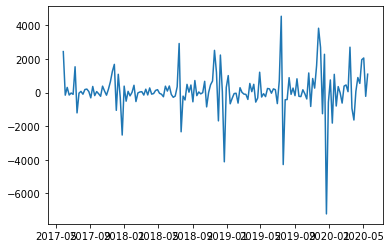

In [87]:
#train_data_diff = train_data1.diff()
#train_data_diff2 = train_data2.diff().fillna(train_data2)
new_train_diff = new_train1.diff().fillna(new_train1)
pyplot.plot(new_train_diff)
plt.show()


In [125]:
new_train_diff

ship_week
2017-05-28    2438.0
2017-06-04    -154.0
2017-06-11     307.0
2017-06-18    -147.0
2017-06-25     -27.0
               ...  
2020-04-19     546.0
2020-04-26    1954.0
2020-05-03    2057.0
2020-05-10    -224.0
2020-05-17    1093.0
Name: pkgs, Length: 156, dtype: float64

In [108]:
#test for stationary using ADF test 
ad_fuller_result = adfuller(new_train_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -14.539490590885732
p-value: 5.1736166118473986e-27


## ACF & PACF Plots

In [97]:
#plot_acf(train_data_diff2, lags=20)
#plot_pacf(train_data_diff2, lags=20)

## Fitting Model 

In [153]:
pip install tqdm 

     |████████████████████████████████| 75 kB 6.6 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [118]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools 
import pmdarima as pm

In [25]:
pip install pmdarima

     |████████████████████████████████| 1.5 MB 19.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## pmdarima function

In [124]:
# Untransfromed data 

import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(new_train1, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=52,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1739.664, Time=5.97 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1747.103, Time=0.52 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1739.980, Time=1.04 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1738.437, Time=1.30 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1736.517, Time=0.29 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1738.430, Time=1.26 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=8.25 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=1737.803, Time=0.88 sec
 ARIMA(0,1,2)(0,1,0)[52]             : AIC=1738.213, Time=0.73 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1738.004, Time=0.18 sec
 ARIMA(1,1,2)(0,1,0)[52]             : AIC=1739.045, Time=0.94 sec
 ARIMA(0,1,1)(0,1,0)[52] intercept   : AIC=1737.074, Time=0.70 sec

Best model:  ARIMA(0,1,1)(0,1,0)[52]          
Total fit time: 22.108 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 52)   Log Likelihood                -866.258
Date:                             Sun, 20 Jun 2021   AIC                           1736.517
Time:                                     22:50:24   BIC                           1741.786
Sample:                                          0   HQIC                          1738.651
                                             - 156                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3795      0.071     -5.327      0.000      -0.519      -0.240
sigma2      1.234e+06   9.74e+04     12.672      0.000    1.04e+06    1.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               155.01
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.51   Skew:                             1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
#transformed data 
# Seasonal - fit stepwise auto-ARIMA
smodel1 = pm.auto_arima(new_train_diff, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=52,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel1.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=1759.926, Time=6.53 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1767.875, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1760.884, Time=1.29 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1759.096, Time=3.74 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1766.194, Time=0.12 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1757.101, Time=0.58 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=1759.095, Time=3.41 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=4.34 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1757.908, Time=1.54 sec
 ARIMA(0,0,2)(0,1,0)[52] intercept   : AIC=1758.782, Time=0.97 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1758.931, Time=0.29 sec
 ARIMA(1,0,2)(0,1,0)[52] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(0,0,1)(0,1,0)[52]             : AIC=1755.980, Time=0.20 sec
 ARIMA(0,0,1)(1,1,0)[52]             : AIC=1757.979, Time=1.00 sec
 ARIMA(0,0,1)(0,1,1)[52]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  156
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 52)   Log Likelihood                -875.990
Date:                             Sun, 20 Jun 2021   AIC                           1755.980
Time:                                     22:42:32   BIC                           1761.269
Sample:                                          0   HQIC                          1758.123
                                             - 156                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3739      0.070     -5.342      0.000      -0.511      -0.237
sigma2      1.222e+06   9.51e+04     12.858      0.000    1.04e+06    1.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               138.13
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## US Forecast Parameters 

In [126]:
CA_best_model = SARIMAX(new_train1, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                pkgs   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -870.404
Date:                             Sun, 20 Jun 2021   AIC                           1746.807
Time:                                     22:54:49   BIC                           1754.712
Sample:                                 05-28-2017   HQIC                          1750.009
                                      - 05-17-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3158      0.064     -4.947      0.000      -0.441      -0.191
ma.L1         -0.9999      

In [127]:
CA_best_model1 = SARIMAX(new_train_diff, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                pkgs   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -870.404
Date:                             Sun, 20 Jun 2021   AIC                           1746.807
Time:                                     22:54:58   BIC                           1754.712
Sample:                                 05-28-2017   HQIC                          1750.009
                                      - 05-17-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3158      0.064     -4.947      0.000      -0.441      -0.191
ma.L1         -0.9999      

In [128]:
pred =CA_best_model.predict(start=156, end=156+52-1)
pred.tail(20)

2021-01-03    20027.733446
2021-01-10    18210.733446
2021-01-17    19295.733446
2021-01-24    18495.733446
2021-01-31    18850.733446
2021-02-07    18829.733446
2021-02-14    18203.733446
2021-02-21    18590.733446
2021-02-28    19042.733446
2021-03-07    19095.733446
2021-03-14    21795.733446
2021-03-21    20853.733446
2021-03-28    19220.733446
2021-04-04    19292.733446
2021-04-11    20186.733446
2021-04-18    20732.733446
2021-04-25    22686.733446
2021-05-02    24743.733446
2021-05-09    24519.733446
2021-05-16    25612.733446
Freq: W-SUN, Name: predicted_mean, dtype: float64

## forecasts

In [129]:
fcst_data = new_zip1[-3*52:]
fcst_data1 =fcst_data.iloc[:,1] 
fcst_data1

ship_week
2018-06-24     4133
2018-07-01     3926
2018-07-08     4272
2018-07-15     7192
2018-07-22     4858
              ...  
2021-05-16    17145
2021-05-23    17811
2021-05-30    17214
2021-06-06    17273
2021-06-13    16790
Name: pkgs, Length: 156, dtype: int64

In [134]:
fct_best_model = SARIMAX(fcst_data1, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
print(fct_best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                pkgs   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -912.911
Date:                             Sun, 20 Jun 2021   AIC                           1831.822
Time:                                     23:10:31   BIC                           1839.726
Sample:                                 06-24-2018   HQIC                          1835.023
                                      - 06-13-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2789      0.296      0.943      0.346      -0.301       0.859
ma.L1         -0.5962      

In [133]:
fct = fct_best_model.predict(start=156, end=156+352-1)
#fct = fct_best_model.predict(fcst_data1)
fct.tail(20)

2027-10-31    26379.9813
2027-11-07    29576.9813
2027-11-14    33830.9813
2027-11-21    35134.9813
2027-11-28    34030.9813
2027-12-05    35838.9813
2027-12-12    24376.9813
2027-12-19    26202.9813
2027-12-26    27803.9813
2028-01-02    24384.9813
2028-01-09    24356.9813
2028-01-16    24392.9813
2028-01-23    24051.9813
2028-01-30    23678.9813
2028-02-06    22644.9813
2028-02-13    23646.9813
2028-02-20    23429.9813
2028-02-27    23340.9813
2028-03-05    21536.9813
2028-03-12    20859.9813
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [137]:
#for_v_act= pd.merge(data_fct1, data_pred1, on=['ship_week'], 
                    #how='inner', suffixes= ('_fct', '_act'))
#for_v_act.head()

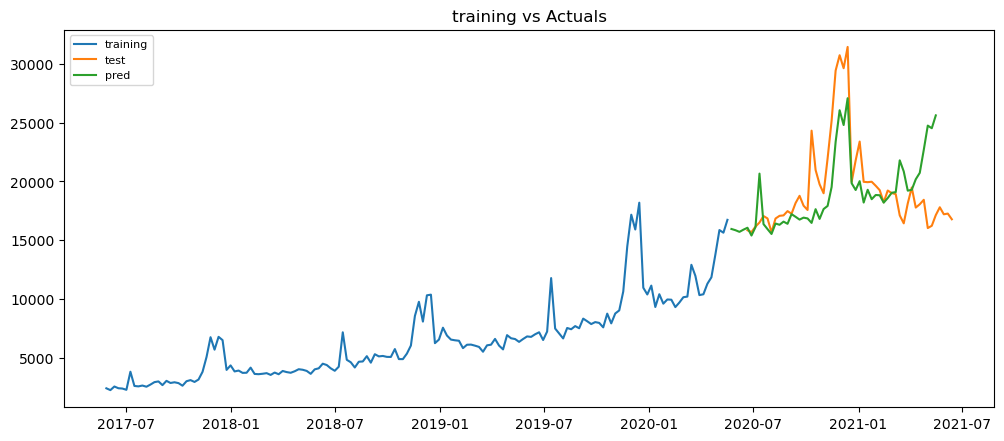

In [141]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(new_train1, label='training')
plt.plot(new_test1, label='test')
plt.plot(pred, label='pred')
plt.title('training vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

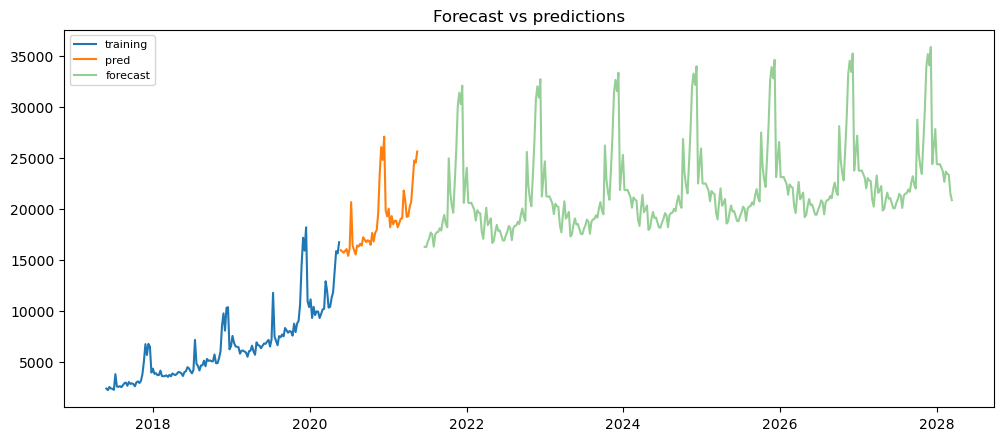

In [142]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(new_train1, label='training')
plt.plot(pred, label='pred')
plt.plot(fct, label='forecast', alpha=.5)
#plt.plot(data_fct1.loc[(data_fct1.ship_week<'2021-07-01')]['ship_week'], data_fct1.loc[(data_fct1.ship_week<'2021-07-01')]['pkgs_num'],
#label ='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs predictions')
plt.legend(loc='upper left', fontsize=8)
plt.show()